Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [19]:
# Maplotlib and numpy 
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# Tensorflow
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import funs
# Lorenz attractor
from Lorenz_Attractor import sample_traj_lorenz

# Sample from latent Lorenz attractor:


In [2]:
Time = 100
neuron_num = 50
traj = sample_traj_lorenz(T = Time,speed_up = 4,initial_offset = 10000)

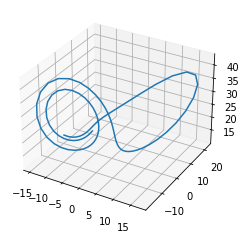

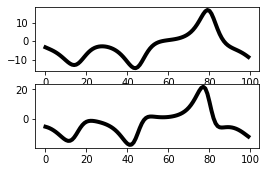

In [3]:
# We sample 20 latent trajectories and project them into 50 output neurons using random weights:

Factor = np.random.randn(3,neuron_num)

NRep=1
output = np.zeros((NRep,Time,neuron_num))

for i in range(NRep):
    traj = sample_traj_lorenz(T = Time,speed_up = 4,initial_offset = 10000)
    output[i,:,:] = traj @ Factor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:,0],traj[:,1],traj[:,2])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)

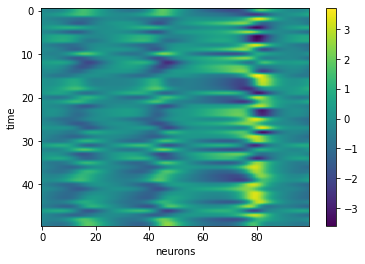

In [4]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('neurons')
plt.ylabel('time')
plt.colorbar()
plt.show()

In [5]:
# Create Tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((output))
dataset = dataset.shuffle(20, reshuffle_each_iteration=True)

# Autoencoder Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=3,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        self.dense_output = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        xo = self.dense_output(x)
        return xo, x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=3,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)[0]
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    def latent(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        latent = self.decoder(z)[1]
        return latent

In [11]:
BATCH_SIZE = 20
batched_dataset = dataset.batch(BATCH_SIZE)

In [12]:
vae = VariationalAutoEncoder(latent_dim=64,
                             num_gru_unit=128,
                             sequence_length=Time,
                             num_input_neuron=neuron_num,
                             num_factor=3)

# Train Model

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [14]:
KL_penalty = np.linspace(0,1,4)

In [15]:
epochs = 1000

for i,kl_ in enumerate(KL_penalty):
    
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:
                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))

Start of epoch 0
step 0: mean loss = 1.0021155
Start of epoch 1
step 0: mean loss = 1.0029399
Start of epoch 2
step 0: mean loss = 1.0022949
Start of epoch 3
step 0: mean loss = 1.0024711
Start of epoch 4
step 0: mean loss = 1.0023272
Start of epoch 5
step 0: mean loss = 1.0021509
Start of epoch 6
step 0: mean loss = 1.0018922
Start of epoch 7
step 0: mean loss = 1.0018327
Start of epoch 8
step 0: mean loss = 1.001749
Start of epoch 9
step 0: mean loss = 1.0016117
Start of epoch 10
step 0: mean loss = 1.0015807
Start of epoch 11
step 0: mean loss = 1.0015064
Start of epoch 12
step 0: mean loss = 1.0014573
Start of epoch 13
step 0: mean loss = 1.0015037
Start of epoch 14
step 0: mean loss = 1.0015813
Start of epoch 15
step 0: mean loss = 1.0015447
Start of epoch 16
step 0: mean loss = 1.0014867
Start of epoch 17
step 0: mean loss = 1.0014348
Start of epoch 18
step 0: mean loss = 1.0013802
Start of epoch 19
step 0: mean loss = 1.0012996
Start of epoch 20
step 0: mean loss = 1.0012335
Sta

step 0: mean loss = 0.8069355
Start of epoch 169
step 0: mean loss = 0.80450684
Start of epoch 170
step 0: mean loss = 0.80360883
Start of epoch 171
step 0: mean loss = 0.8009206
Start of epoch 172
step 0: mean loss = 0.79962385
Start of epoch 173
step 0: mean loss = 0.7968902
Start of epoch 174
step 0: mean loss = 0.79533607
Start of epoch 175
step 0: mean loss = 0.79259706
Start of epoch 176
step 0: mean loss = 0.7909847
Start of epoch 177
step 0: mean loss = 0.7881978
Start of epoch 178
step 0: mean loss = 0.7871973
Start of epoch 179
step 0: mean loss = 0.78453207
Start of epoch 180
step 0: mean loss = 0.7822143
Start of epoch 181
step 0: mean loss = 0.7794032
Start of epoch 182
step 0: mean loss = 0.7771693
Start of epoch 183
step 0: mean loss = 0.7745743
Start of epoch 184
step 0: mean loss = 0.77194595
Start of epoch 185
step 0: mean loss = 0.7695927
Start of epoch 186
step 0: mean loss = 0.7666799
Start of epoch 187
step 0: mean loss = 0.7640397
Start of epoch 188
step 0: mean 

step 0: mean loss = 0.4625119
Start of epoch 335
step 0: mean loss = 0.46115538
Start of epoch 336
step 0: mean loss = 0.45980898
Start of epoch 337
step 0: mean loss = 0.45846918
Start of epoch 338
step 0: mean loss = 0.45713618
Start of epoch 339
step 0: mean loss = 0.45581606
Start of epoch 340
step 0: mean loss = 0.4545029
Start of epoch 341
step 0: mean loss = 0.45319328
Start of epoch 342
step 0: mean loss = 0.451889
Start of epoch 343
step 0: mean loss = 0.45060033
Start of epoch 344
step 0: mean loss = 0.44933653
Start of epoch 345
step 0: mean loss = 0.44808003
Start of epoch 346
step 0: mean loss = 0.44682217
Start of epoch 347
step 0: mean loss = 0.44556287
Start of epoch 348
step 0: mean loss = 0.44430354
Start of epoch 349
step 0: mean loss = 0.44304854
Start of epoch 350
step 0: mean loss = 0.44180116
Start of epoch 351
step 0: mean loss = 0.4405609
Start of epoch 352
step 0: mean loss = 0.43932652
Start of epoch 353
step 0: mean loss = 0.4380988
Start of epoch 354
step 0

step 0: mean loss = 0.3118648
Start of epoch 500
step 0: mean loss = 0.31125575
Start of epoch 501
step 0: mean loss = 0.31064662
Start of epoch 502
step 0: mean loss = 0.3100382
Start of epoch 503
step 0: mean loss = 0.3094311
Start of epoch 504
step 0: mean loss = 0.3088263
Start of epoch 505
step 0: mean loss = 0.3082249
Start of epoch 506
step 0: mean loss = 0.30762863
Start of epoch 507
step 0: mean loss = 0.30703518
Start of epoch 508
step 0: mean loss = 0.3064394
Start of epoch 509
step 0: mean loss = 0.30584186
Start of epoch 510
step 0: mean loss = 0.3052449
Start of epoch 511
step 0: mean loss = 0.30465236
Start of epoch 512
step 0: mean loss = 0.30406845
Start of epoch 513
step 0: mean loss = 0.30349115
Start of epoch 514
step 0: mean loss = 0.30291158
Start of epoch 515
step 0: mean loss = 0.30232862
Start of epoch 516
step 0: mean loss = 0.3017461
Start of epoch 517
step 0: mean loss = 0.3011653
Start of epoch 518
step 0: mean loss = 0.30058664
Start of epoch 519
step 0: m

step 0: mean loss = 0.23609555
Start of epoch 665
step 0: mean loss = 0.23574838
Start of epoch 666
step 0: mean loss = 0.23539677
Start of epoch 667
step 0: mean loss = 0.2350455
Start of epoch 668
step 0: mean loss = 0.2346972
Start of epoch 669
step 0: mean loss = 0.23435208
Start of epoch 670
step 0: mean loss = 0.23400965
Start of epoch 671
step 0: mean loss = 0.23366733
Start of epoch 672
step 0: mean loss = 0.23332348
Start of epoch 673
step 0: mean loss = 0.23297837
Start of epoch 674
step 0: mean loss = 0.2326351
Start of epoch 675
step 0: mean loss = 0.23229843
Start of epoch 676
step 0: mean loss = 0.23196936
Start of epoch 677
step 0: mean loss = 0.23163895
Start of epoch 678
step 0: mean loss = 0.23130047
Start of epoch 679
step 0: mean loss = 0.23096228
Start of epoch 680
step 0: mean loss = 0.23062645
Start of epoch 681
step 0: mean loss = 0.2302897
Start of epoch 682
step 0: mean loss = 0.2299547
Start of epoch 683
step 0: mean loss = 0.22962862
Start of epoch 684
step 

step 0: mean loss = 0.19004045
Start of epoch 830
step 0: mean loss = 0.18981265
Start of epoch 831
step 0: mean loss = 0.1895849
Start of epoch 832
step 0: mean loss = 0.18935764
Start of epoch 833
step 0: mean loss = 0.18913117
Start of epoch 834
step 0: mean loss = 0.1889068
Start of epoch 835
step 0: mean loss = 0.18868773
Start of epoch 836
step 0: mean loss = 0.18847556
Start of epoch 837
step 0: mean loss = 0.18827294
Start of epoch 838
step 0: mean loss = 0.18808249
Start of epoch 839
step 0: mean loss = 0.1879013
Start of epoch 840
step 0: mean loss = 0.18771176
Start of epoch 841
step 0: mean loss = 0.18750615
Start of epoch 842
step 0: mean loss = 0.18728687
Start of epoch 843
step 0: mean loss = 0.18706658
Start of epoch 844
step 0: mean loss = 0.18685596
Start of epoch 845
step 0: mean loss = 0.18665718
Start of epoch 846
step 0: mean loss = 0.1864659
Start of epoch 847
step 0: mean loss = 0.18626991
Start of epoch 848
step 0: mean loss = 0.18606335
Start of epoch 849
step

step 0: mean loss = 0.15957902
Start of epoch 995
step 0: mean loss = 0.15942201
Start of epoch 996
step 0: mean loss = 0.15926386
Start of epoch 997
step 0: mean loss = 0.15910478
Start of epoch 998
step 0: mean loss = 0.15894592
Start of epoch 999
step 0: mean loss = 0.15878825
Start of epoch 0
step 0: mean loss = 0.1635668
Start of epoch 1
step 0: mean loss = 0.16729726
Start of epoch 2
step 0: mean loss = 0.16978817
Start of epoch 3
step 0: mean loss = 0.17145485
Start of epoch 4
step 0: mean loss = 0.17309184
Start of epoch 5
step 0: mean loss = 0.17777786
Start of epoch 6
step 0: mean loss = 0.1804384
Start of epoch 7
step 0: mean loss = 0.18235719
Start of epoch 8
step 0: mean loss = 0.1841229
Start of epoch 9
step 0: mean loss = 0.18592557
Start of epoch 10
step 0: mean loss = 0.18790546
Start of epoch 11
step 0: mean loss = 0.19047219
Start of epoch 12
step 0: mean loss = 0.19251579
Start of epoch 13
step 0: mean loss = 0.19425373
Start of epoch 14
step 0: mean loss = 0.196225

step 0: mean loss = 0.2960737
Start of epoch 162
step 0: mean loss = 0.29622898
Start of epoch 163
step 0: mean loss = 0.29634267
Start of epoch 164
step 0: mean loss = 0.2964551
Start of epoch 165
step 0: mean loss = 0.29661575
Start of epoch 166
step 0: mean loss = 0.29708382
Start of epoch 167
step 0: mean loss = 0.29729003
Start of epoch 168
step 0: mean loss = 0.29740852
Start of epoch 169
step 0: mean loss = 0.29762745
Start of epoch 170
step 0: mean loss = 0.29778108
Start of epoch 171
step 0: mean loss = 0.2980028
Start of epoch 172
step 0: mean loss = 0.298971
Start of epoch 173
step 0: mean loss = 0.29962012
Start of epoch 174
step 0: mean loss = 0.2999385
Start of epoch 175
step 0: mean loss = 0.30005053
Start of epoch 176
step 0: mean loss = 0.3006465
Start of epoch 177
step 0: mean loss = 0.3013001
Start of epoch 178
step 0: mean loss = 0.30221048
Start of epoch 179
step 0: mean loss = 0.30385366
Start of epoch 180
step 0: mean loss = 0.30461022
Start of epoch 181
step 0: 

step 0: mean loss = 0.35410938
Start of epoch 328
step 0: mean loss = 0.35402703
Start of epoch 329
step 0: mean loss = 0.3540838
Start of epoch 330
step 0: mean loss = 0.35403663
Start of epoch 331
step 0: mean loss = 0.35398048
Start of epoch 332
step 0: mean loss = 0.35401997
Start of epoch 333
step 0: mean loss = 0.35400978
Start of epoch 334
step 0: mean loss = 0.35396597
Start of epoch 335
step 0: mean loss = 0.35400122
Start of epoch 336
step 0: mean loss = 0.35392064
Start of epoch 337
step 0: mean loss = 0.35387775
Start of epoch 338
step 0: mean loss = 0.3537751
Start of epoch 339
step 0: mean loss = 0.35377818
Start of epoch 340
step 0: mean loss = 0.3536848
Start of epoch 341
step 0: mean loss = 0.35364923
Start of epoch 342
step 0: mean loss = 0.35361397
Start of epoch 343
step 0: mean loss = 0.35350147
Start of epoch 344
step 0: mean loss = 0.35345814
Start of epoch 345
step 0: mean loss = 0.3534715
Start of epoch 346
step 0: mean loss = 0.35334632
Start of epoch 347
step

step 0: mean loss = 0.3481565
Start of epoch 494
step 0: mean loss = 0.34822768
Start of epoch 495
step 0: mean loss = 0.348396
Start of epoch 496
step 0: mean loss = 0.34864044
Start of epoch 497
step 0: mean loss = 0.3487354
Start of epoch 498
step 0: mean loss = 0.34873852
Start of epoch 499
step 0: mean loss = 0.3488806
Start of epoch 500
step 0: mean loss = 0.34894428
Start of epoch 501
step 0: mean loss = 0.348935
Start of epoch 502
step 0: mean loss = 0.34887168
Start of epoch 503
step 0: mean loss = 0.34886125
Start of epoch 504
step 0: mean loss = 0.3488728
Start of epoch 505
step 0: mean loss = 0.34880993
Start of epoch 506
step 0: mean loss = 0.34872857
Start of epoch 507
step 0: mean loss = 0.34870484
Start of epoch 508
step 0: mean loss = 0.34867933
Start of epoch 509
step 0: mean loss = 0.34856373
Start of epoch 510
step 0: mean loss = 0.34862077
Start of epoch 511
step 0: mean loss = 0.34851184
Start of epoch 512
step 0: mean loss = 0.3484018
Start of epoch 513
step 0: m

step 0: mean loss = 0.33643386
Start of epoch 660
step 0: mean loss = 0.33634153
Start of epoch 661
step 0: mean loss = 0.33623907
Start of epoch 662
step 0: mean loss = 0.33614218
Start of epoch 663
step 0: mean loss = 0.33601806
Start of epoch 664
step 0: mean loss = 0.3358938
Start of epoch 665
step 0: mean loss = 0.33578494
Start of epoch 666
step 0: mean loss = 0.3357522
Start of epoch 667
step 0: mean loss = 0.33562395
Start of epoch 668
step 0: mean loss = 0.33552283
Start of epoch 669
step 0: mean loss = 0.33539346
Start of epoch 670
step 0: mean loss = 0.33527038
Start of epoch 671
step 0: mean loss = 0.33513772
Start of epoch 672
step 0: mean loss = 0.33506155
Start of epoch 673
step 0: mean loss = 0.3349322
Start of epoch 674
step 0: mean loss = 0.3348084
Start of epoch 675
step 0: mean loss = 0.33467492
Start of epoch 676
step 0: mean loss = 0.33455014
Start of epoch 677
step 0: mean loss = 0.33440596
Start of epoch 678
step 0: mean loss = 0.33426973
Start of epoch 679
step

step 0: mean loss = 0.32760748
Start of epoch 825
step 0: mean loss = 0.3274956
Start of epoch 826
step 0: mean loss = 0.32745868
Start of epoch 827
step 0: mean loss = 0.32746118
Start of epoch 828
step 0: mean loss = 0.32738897
Start of epoch 829
step 0: mean loss = 0.3273376
Start of epoch 830
step 0: mean loss = 0.32728365
Start of epoch 831
step 0: mean loss = 0.32723188
Start of epoch 832
step 0: mean loss = 0.32715836
Start of epoch 833
step 0: mean loss = 0.32708392
Start of epoch 834
step 0: mean loss = 0.3270585
Start of epoch 835
step 0: mean loss = 0.32703906
Start of epoch 836
step 0: mean loss = 0.32700264
Start of epoch 837
step 0: mean loss = 0.32692143
Start of epoch 838
step 0: mean loss = 0.32683653
Start of epoch 839
step 0: mean loss = 0.32673714
Start of epoch 840
step 0: mean loss = 0.3266406
Start of epoch 841
step 0: mean loss = 0.3265513
Start of epoch 842
step 0: mean loss = 0.3264416
Start of epoch 843
step 0: mean loss = 0.32633027
Start of epoch 844
step 0

step 0: mean loss = 0.31683132
Start of epoch 991
step 0: mean loss = 0.31723163
Start of epoch 992
step 0: mean loss = 0.31745595
Start of epoch 993
step 0: mean loss = 0.31774333
Start of epoch 994
step 0: mean loss = 0.31797704
Start of epoch 995
step 0: mean loss = 0.3180993
Start of epoch 996
step 0: mean loss = 0.31819686
Start of epoch 997
step 0: mean loss = 0.31835854
Start of epoch 998
step 0: mean loss = 0.31845072
Start of epoch 999
step 0: mean loss = 0.3184747
Start of epoch 0
step 0: mean loss = 0.31865802
Start of epoch 1
step 0: mean loss = 0.31884766
Start of epoch 2
step 0: mean loss = 0.31894255
Start of epoch 3
step 0: mean loss = 0.31903803
Start of epoch 4
step 0: mean loss = 0.31903544
Start of epoch 5
step 0: mean loss = 0.31904253
Start of epoch 6
step 0: mean loss = 0.31903836
Start of epoch 7
step 0: mean loss = 0.3190298
Start of epoch 8
step 0: mean loss = 0.31902137
Start of epoch 9
step 0: mean loss = 0.3189973
Start of epoch 10
step 0: mean loss = 0.319

step 0: mean loss = 0.32455388
Start of epoch 159
step 0: mean loss = 0.3248744
Start of epoch 160
step 0: mean loss = 0.32513684
Start of epoch 161
step 0: mean loss = 0.3253545
Start of epoch 162
step 0: mean loss = 0.32552457
Start of epoch 163
step 0: mean loss = 0.3256671
Start of epoch 164
step 0: mean loss = 0.32575285
Start of epoch 165
step 0: mean loss = 0.3258034
Start of epoch 166
step 0: mean loss = 0.32583728
Start of epoch 167
step 0: mean loss = 0.3258454
Start of epoch 168
step 0: mean loss = 0.3258298
Start of epoch 169
step 0: mean loss = 0.32580134
Start of epoch 170
step 0: mean loss = 0.32576764
Start of epoch 171
step 0: mean loss = 0.32572258
Start of epoch 172
step 0: mean loss = 0.3257865
Start of epoch 173
step 0: mean loss = 0.32578972
Start of epoch 174
step 0: mean loss = 0.32596698
Start of epoch 175
step 0: mean loss = 0.32630876
Start of epoch 176
step 0: mean loss = 0.32677642
Start of epoch 177
step 0: mean loss = 0.32732865
Start of epoch 178
step 0:

step 0: mean loss = 0.32919914
Start of epoch 324
step 0: mean loss = 0.3291866
Start of epoch 325
step 0: mean loss = 0.32912818
Start of epoch 326
step 0: mean loss = 0.3290833
Start of epoch 327
step 0: mean loss = 0.32902658
Start of epoch 328
step 0: mean loss = 0.32894722
Start of epoch 329
step 0: mean loss = 0.3289239
Start of epoch 330
step 0: mean loss = 0.32892233
Start of epoch 331
step 0: mean loss = 0.32883808
Start of epoch 332
step 0: mean loss = 0.32887015
Start of epoch 333
step 0: mean loss = 0.32899415
Start of epoch 334
step 0: mean loss = 0.32894504
Start of epoch 335
step 0: mean loss = 0.32893473
Start of epoch 336
step 0: mean loss = 0.32893884
Start of epoch 337
step 0: mean loss = 0.328931
Start of epoch 338
step 0: mean loss = 0.32892257
Start of epoch 339
step 0: mean loss = 0.3289761
Start of epoch 340
step 0: mean loss = 0.32896048
Start of epoch 341
step 0: mean loss = 0.32892027
Start of epoch 342
step 0: mean loss = 0.32888883
Start of epoch 343
step 0

step 0: mean loss = 0.32396582
Start of epoch 489
step 0: mean loss = 0.32392326
Start of epoch 490
step 0: mean loss = 0.32390636
Start of epoch 491
step 0: mean loss = 0.32390416
Start of epoch 492
step 0: mean loss = 0.32388216
Start of epoch 493
step 0: mean loss = 0.32386425
Start of epoch 494
step 0: mean loss = 0.3238626
Start of epoch 495
step 0: mean loss = 0.32384062
Start of epoch 496
step 0: mean loss = 0.3238102
Start of epoch 497
step 0: mean loss = 0.32379565
Start of epoch 498
step 0: mean loss = 0.32375923
Start of epoch 499
step 0: mean loss = 0.32371077
Start of epoch 500
step 0: mean loss = 0.32366925
Start of epoch 501
step 0: mean loss = 0.32360995
Start of epoch 502
step 0: mean loss = 0.3235418
Start of epoch 503
step 0: mean loss = 0.32346806
Start of epoch 504
step 0: mean loss = 0.32340184
Start of epoch 505
step 0: mean loss = 0.32331857
Start of epoch 506
step 0: mean loss = 0.32323453
Start of epoch 507
step 0: mean loss = 0.32314986
Start of epoch 508
ste

step 0: mean loss = 0.32220045
Start of epoch 654
step 0: mean loss = 0.32221237
Start of epoch 655
step 0: mean loss = 0.32220295
Start of epoch 656
step 0: mean loss = 0.32218403
Start of epoch 657
step 0: mean loss = 0.3221543
Start of epoch 658
step 0: mean loss = 0.32210988
Start of epoch 659
step 0: mean loss = 0.32205984
Start of epoch 660
step 0: mean loss = 0.32200766
Start of epoch 661
step 0: mean loss = 0.32196474
Start of epoch 662
step 0: mean loss = 0.32189757
Start of epoch 663
step 0: mean loss = 0.3218409
Start of epoch 664
step 0: mean loss = 0.32176822
Start of epoch 665
step 0: mean loss = 0.3217086
Start of epoch 666
step 0: mean loss = 0.32168972
Start of epoch 667
step 0: mean loss = 0.3216506
Start of epoch 668
step 0: mean loss = 0.3215944
Start of epoch 669
step 0: mean loss = 0.3215484
Start of epoch 670
step 0: mean loss = 0.3215016
Start of epoch 671
step 0: mean loss = 0.32144243
Start of epoch 672
step 0: mean loss = 0.32138368
Start of epoch 673
step 0:

step 0: mean loss = 0.32095927
Start of epoch 819
step 0: mean loss = 0.32095668
Start of epoch 820
step 0: mean loss = 0.32095882
Start of epoch 821
step 0: mean loss = 0.3209553
Start of epoch 822
step 0: mean loss = 0.32093418
Start of epoch 823
step 0: mean loss = 0.32090428
Start of epoch 824
step 0: mean loss = 0.32088178
Start of epoch 825
step 0: mean loss = 0.3208471
Start of epoch 826
step 0: mean loss = 0.3208005
Start of epoch 827
step 0: mean loss = 0.3207541
Start of epoch 828
step 0: mean loss = 0.32069516
Start of epoch 829
step 0: mean loss = 0.32063878
Start of epoch 830
step 0: mean loss = 0.32057592
Start of epoch 831
step 0: mean loss = 0.32050982
Start of epoch 832
step 0: mean loss = 0.32048756
Start of epoch 833
step 0: mean loss = 0.32041347
Start of epoch 834
step 0: mean loss = 0.3203411
Start of epoch 835
step 0: mean loss = 0.3203116
Start of epoch 836
step 0: mean loss = 0.320241
Start of epoch 837
step 0: mean loss = 0.3201706
Start of epoch 838
step 0: m

step 0: mean loss = 0.33112448
Start of epoch 984
step 0: mean loss = 0.33115953
Start of epoch 985
step 0: mean loss = 0.33113202
Start of epoch 986
step 0: mean loss = 0.3310918
Start of epoch 987
step 0: mean loss = 0.33106145
Start of epoch 988
step 0: mean loss = 0.33104783
Start of epoch 989
step 0: mean loss = 0.3310156
Start of epoch 990
step 0: mean loss = 0.3309516
Start of epoch 991
step 0: mean loss = 0.33089104
Start of epoch 992
step 0: mean loss = 0.3308407
Start of epoch 993
step 0: mean loss = 0.3307707
Start of epoch 994
step 0: mean loss = 0.3307029
Start of epoch 995
step 0: mean loss = 0.33061755
Start of epoch 996
step 0: mean loss = 0.3305303
Start of epoch 997
step 0: mean loss = 0.33044234
Start of epoch 998
step 0: mean loss = 0.33036092
Start of epoch 999
step 0: mean loss = 0.33027545
Start of epoch 0
step 0: mean loss = 0.33027408
Start of epoch 1
step 0: mean loss = 0.3302106
Start of epoch 2
step 0: mean loss = 0.3301825
Start of epoch 3
step 0: mean loss

step 0: mean loss = 0.32893154
Start of epoch 152
step 0: mean loss = 0.32886833
Start of epoch 153
step 0: mean loss = 0.32881752
Start of epoch 154
step 0: mean loss = 0.32876614
Start of epoch 155
step 0: mean loss = 0.3287094
Start of epoch 156
step 0: mean loss = 0.32866147
Start of epoch 157
step 0: mean loss = 0.328613
Start of epoch 158
step 0: mean loss = 0.32855478
Start of epoch 159
step 0: mean loss = 0.3285066
Start of epoch 160
step 0: mean loss = 0.3284511
Start of epoch 161
step 0: mean loss = 0.328384
Start of epoch 162
step 0: mean loss = 0.32845062
Start of epoch 163
step 0: mean loss = 0.32849053
Start of epoch 164
step 0: mean loss = 0.3286116
Start of epoch 165
step 0: mean loss = 0.3287421
Start of epoch 166
step 0: mean loss = 0.32885468
Start of epoch 167
step 0: mean loss = 0.32904214
Start of epoch 168
step 0: mean loss = 0.32926747
Start of epoch 169
step 0: mean loss = 0.32941592
Start of epoch 170
step 0: mean loss = 0.32952297
Start of epoch 171
step 0: m

step 0: mean loss = 0.34785068
Start of epoch 318
step 0: mean loss = 0.34778866
Start of epoch 319
step 0: mean loss = 0.347747
Start of epoch 320
step 0: mean loss = 0.34768292
Start of epoch 321
step 0: mean loss = 0.34763807
Start of epoch 322
step 0: mean loss = 0.34758177
Start of epoch 323
step 0: mean loss = 0.34752688
Start of epoch 324
step 0: mean loss = 0.34746066
Start of epoch 325
step 0: mean loss = 0.34741327
Start of epoch 326
step 0: mean loss = 0.34735414
Start of epoch 327
step 0: mean loss = 0.347287
Start of epoch 328
step 0: mean loss = 0.3472289
Start of epoch 329
step 0: mean loss = 0.34714958
Start of epoch 330
step 0: mean loss = 0.34708014
Start of epoch 331
step 0: mean loss = 0.34703517
Start of epoch 332
step 0: mean loss = 0.34696957
Start of epoch 333
step 0: mean loss = 0.34692162
Start of epoch 334
step 0: mean loss = 0.3468478
Start of epoch 335
step 0: mean loss = 0.34678382
Start of epoch 336
step 0: mean loss = 0.3467068
Start of epoch 337
step 0:

step 0: mean loss = 0.3466888
Start of epoch 483
step 0: mean loss = 0.34668744
Start of epoch 484
step 0: mean loss = 0.34666017
Start of epoch 485
step 0: mean loss = 0.34662718
Start of epoch 486
step 0: mean loss = 0.34660208
Start of epoch 487
step 0: mean loss = 0.34659874
Start of epoch 488
step 0: mean loss = 0.34655356
Start of epoch 489
step 0: mean loss = 0.3465417
Start of epoch 490
step 0: mean loss = 0.34649563
Start of epoch 491
step 0: mean loss = 0.34644824
Start of epoch 492
step 0: mean loss = 0.34638396
Start of epoch 493
step 0: mean loss = 0.34631917
Start of epoch 494
step 0: mean loss = 0.34626004
Start of epoch 495
step 0: mean loss = 0.34624875
Start of epoch 496
step 0: mean loss = 0.34618878
Start of epoch 497
step 0: mean loss = 0.3461369
Start of epoch 498
step 0: mean loss = 0.3461407
Start of epoch 499
step 0: mean loss = 0.3460989
Start of epoch 500
step 0: mean loss = 0.34602812
Start of epoch 501
step 0: mean loss = 0.34596583
Start of epoch 502
step 

step 0: mean loss = 0.39754546
Start of epoch 648
step 0: mean loss = 0.3975339
Start of epoch 649
step 0: mean loss = 0.39755464
Start of epoch 650
step 0: mean loss = 0.39752322
Start of epoch 651
step 0: mean loss = 0.39749855
Start of epoch 652
step 0: mean loss = 0.3974518
Start of epoch 653
step 0: mean loss = 0.3974044
Start of epoch 654
step 0: mean loss = 0.39735138
Start of epoch 655
step 0: mean loss = 0.39729583
Start of epoch 656
step 0: mean loss = 0.39723116
Start of epoch 657
step 0: mean loss = 0.39717573
Start of epoch 658
step 0: mean loss = 0.39712086
Start of epoch 659
step 0: mean loss = 0.39706838
Start of epoch 660
step 0: mean loss = 0.3970027
Start of epoch 661
step 0: mean loss = 0.39694726
Start of epoch 662
step 0: mean loss = 0.39688283
Start of epoch 663
step 0: mean loss = 0.3968113
Start of epoch 664
step 0: mean loss = 0.39673764
Start of epoch 665
step 0: mean loss = 0.39668405
Start of epoch 666
step 0: mean loss = 0.3966072
Start of epoch 667
step 0

step 0: mean loss = 0.39012542
Start of epoch 813
step 0: mean loss = 0.3900657
Start of epoch 814
step 0: mean loss = 0.38999763
Start of epoch 815
step 0: mean loss = 0.39015147
Start of epoch 816
step 0: mean loss = 0.3901059
Start of epoch 817
step 0: mean loss = 0.39014536
Start of epoch 818
step 0: mean loss = 0.39022377
Start of epoch 819
step 0: mean loss = 0.39033803
Start of epoch 820
step 0: mean loss = 0.39047745
Start of epoch 821
step 0: mean loss = 0.3906483
Start of epoch 822
step 0: mean loss = 0.39082098
Start of epoch 823
step 0: mean loss = 0.39098498
Start of epoch 824
step 0: mean loss = 0.39113346
Start of epoch 825
step 0: mean loss = 0.39128238
Start of epoch 826
step 0: mean loss = 0.39140493
Start of epoch 827
step 0: mean loss = 0.39150468
Start of epoch 828
step 0: mean loss = 0.3915814
Start of epoch 829
step 0: mean loss = 0.39164597
Start of epoch 830
step 0: mean loss = 0.39169168
Start of epoch 831
step 0: mean loss = 0.3917193
Start of epoch 832
step 

step 0: mean loss = 0.3838784
Start of epoch 978
step 0: mean loss = 0.3838037
Start of epoch 979
step 0: mean loss = 0.38373268
Start of epoch 980
step 0: mean loss = 0.3839429
Start of epoch 981
step 0: mean loss = 0.3839602
Start of epoch 982
step 0: mean loss = 0.38418254
Start of epoch 983
step 0: mean loss = 0.3846062
Start of epoch 984
step 0: mean loss = 0.3851966
Start of epoch 985
step 0: mean loss = 0.3859551
Start of epoch 986
step 0: mean loss = 0.38681796
Start of epoch 987
step 0: mean loss = 0.38772142
Start of epoch 988
step 0: mean loss = 0.3886093
Start of epoch 989
step 0: mean loss = 0.38949066
Start of epoch 990
step 0: mean loss = 0.3903411
Start of epoch 991
step 0: mean loss = 0.39111295
Start of epoch 992
step 0: mean loss = 0.39178944
Start of epoch 993
step 0: mean loss = 0.3923895
Start of epoch 994
step 0: mean loss = 0.39291608
Start of epoch 995
step 0: mean loss = 0.39335322
Start of epoch 996
step 0: mean loss = 0.39371353
Start of epoch 997
step 0: me

# Evaluate Quality of reconstruction 

(1, 100, 50)
(1, 100, 3)
(100, 3)
(100, 3)


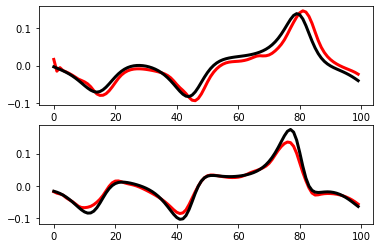

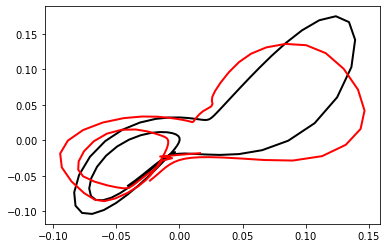

In [36]:
for x in batched_dataset.take(1):
    print(x.shape)
    qz_mean_est = vae.latent(x)
    print(qz_mean_est.shape)

qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
print(qz_est_norm[0].shape)

z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
print(z_true_norm.shape)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm[0]), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[0,:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[0,:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[0,:,0], qz_est_norm_R[0,:,1], lw=2, color = 'r')